

# 31005 Project Report


## Introduction

In this project we implemented the Gradient Boosting regression tree. It is a very popular machine learning method and it is widely used in many different tasks. There are already many off the shelf good implementations of this method including [xgboost](https://github.com/dmlc/xgboost) and [LightGBM](https://github.com/microsoft/LightGBM), however the best way to learn an algorithm is to implement it from the scratch. In the following sections we will give the detailed derivation of the algorithm and explain some of our design choices.

## Method and Evaluation

The gradient boosting tree method is an additive tree ensemble method. For simplicity and illustration purpose we choose to implement a regression model. We will discuss about the generalization to the decision problem later. 

First, the regression tree model can be described as $y=f(x)=w_L (x)$, where $w_L$ is the function mapping input x to the score at the corresponding leaf, in the following we will abuse the notation and also denote the score at leaf as $w_L$. The tree splits the feature space into multiple regions and hierarchically groups them. Each node in the tree defines a split in the feature space and each input x follows a unique path to descent from the root to a leaf representing a specific region in the feature space. The additive tree ensemble, as its name suggests, is an additive ensemble of multiple trees, we simply add up the prediction score from multiple trees: $y=\sum_kf_k(x)$. 

Next, we describe how do we iteratively learn a new tree and additively combine it into the ensemble. We shall use a regularization term Ω to determine the stopping time and trade off between the bias and the variance of the model to prevent overfitting. We simply chose $\Omega=\gamma T+\frac{1}{2}\lambda\sum_l w_l^2$, where $T$ is the number of leaves and $w_l$ is the score at the leaf $l$, we shall see that this choice of regularization term grants the loss function a simple form. We used the most common quadratic loss so the loss function at each round t is defined as: $L_t=\sum_i(y_i-(\hat{y}_{t-1}+f_t (x_i ))^2 +\Omega(f_t)$, where $y_i$ is the ground truth for each instance $i$ and  $\hat{y}_{t-1}$ is the prediction given by the ensemble at $t-1$. Then we used Taylor expansion to the second order so that:
$$L_t\approx \sum_i[(y_i-\hat{y}_{t-1} )^2+g_i f_t (x_i )+\frac{1}{2} h_i f_t (x_i )^2]+\Omega(f_t ),$$
where $g_i=\frac{\partial L_t}{\partial \hat{y}_{t-1}}=2(\hat{y}_{t-1}-y)$ and $h_i=\frac{\partial^2 L_t}{\partial \hat{y}_{t-1}^2}=2$.

If we substitute the expression of the regularization into the above loss function and group it by leaves then the loss function becomes:
$L_t\approx \sum_l [G_lw_l+\frac{1}{2}(H_l+\lambda)w_l^2]+\gamma T$,
where $G_l=\sum_{i\in l} g_i$ and $H_l=\sum_{i\in l} h_i$ for each leaf $l$. Now if the structure of the tree is fixed then the optimal score $w_l$ of each leaf l is simply $-\frac{G_l}{H_j+λ}$ so the loss function further becomes:
$$L_t\approx-\frac{1}{2}\sum_l\frac{G_l^2}{H_l+λ}+γT$$
Now we are ready to talk about how to build a new tree at round t. We can not enumerate all the tree structures, so we chose to build the tree in greedily. Suppose we want to add a new splitting to a current leaf then the gain is $\frac{1}{2} [G_L^2/(H_L+λ)+G_R^2/(H_R+λ)-(G_L+G_R )^2/(H_L+H_R+λ)]-γ$, the four terms describe the negative loss of the left child, the negative loss of the right child, the loss of the leaf without splitting and the complexity cost of adding an extra leaf, respectively. 

The pseudocode for the final algorithm for split finding is as follows:
```
For each node at the current depth:
    For each feature:
        Sort the samples by the feature value
        Linearly scan the instance to find the split with the greatest gain
    Take the best split among all features
    If the best gain is negative
        Break
```
The above algorithm determines how to build a new tree $f_t$, and then we add $f_t$ to the current ensemble $\hat{y}_{t-1}$ to form the ensemble at the step $t$: $\hat{y}_t=f_t+\epsilon\hat{y}_{t-1}$. Where $\epsilon$ is a step-size parameter to control overfitting and is usually set to $0.1$. The time complexity of growing a tree of depth $K$ is $O(ndK\log{n})$, where $n$ is the number of training instances and $d$ is the number of features.

## Discussion and Conclusion
In this study we implemented a simple gradient boosting regression tree. To deal with decision or classification problems, we can simply replace the quadratic loss function to a sigmoid or a softmax loss function, the corresponding G and H would change but everything else should remain the same. In our implementation we choose to use early stopping for simplicity and controlling of overfitting, another possibly choice is to grow a tree to the maximum depth and then recursively prune the leaves with negative gains. Also this is a proof of concept implementation so it is not quite optimized for speed and doesn't have many controlling parameters and still has a large room for further improvement.
## References
https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf


In [0]:
# First we define the gradient boosting regression tree class and the regression tree class
import numpy as np
from collections import deque


class GBRT:
    def __init__(self, gamma, l, epsilon):
        self.gamma = gamma
        self.l = l  # lambda
        self.epsilon = epsilon
        self.trees = []

    def predict(self, x):
        if not self.trees:
            return 0
        return self.trees[0].predict(x) + sum(map(lambda m: m.predict(x), self.trees[1:]))*self.epsilon

    def add_tree(self, xs, ys):
        yhat = self.predict(xs)
        g = 2*(yhat - ys).reshape(-1)
        plt.show()
        tree = RTree(None, None, None, None, -g.sum()/(2*len(xs)+self.l))  #-G/(H+lambda)
        node_instance_dict = {tree: np.arange(len(xs))}
        node_deque = deque([tree])
        while node_deque:
            node = node_deque.popleft()
            best_gain = 0
            best_feature = None
            best_split = None
            best_weight_left = None
            best_weight_right = None
            best_sorted_instances = None
            best_split_on_instance = None
            for feature in range(xs.shape[1]):
                sorted_instances = sorted(node_instance_dict[node], key=lambda i: xs[i, feature])
                node_instance_dict.pop(node)
                for i in range(len(sorted_instances) - 1):
                    split = (xs[sorted_instances[i], feature] + xs[sorted_instances[i+1], feature])/2
                    gain = (g[sorted_instances[:i+1]]**2).sum()/(2*(i+1)+self.l) +\
                               (g[sorted_instances[i+1:]]**2).sum()/(2*(len(sorted_instances)-i-1)+self.l) -\
                               (g[sorted_instances]**2).sum()/(2*len(sorted_instances)+self.l) - 2*self.gamma
                    weight_left = -g[sorted_instances[:i+1]].sum()/(2*(i+1)+self.l)
                    weight_right = -g[sorted_instances[i+1:]].sum()/(2*(len(sorted_instances)-i-1)+self.l)
                    if gain > best_gain:
                        best_gain = gain
                        best_feature = feature
                        best_split = split
                        best_weight_left = weight_left
                        best_weight_right = weight_right
                        best_sorted_instances = sorted_instances
                        best_split_on_instance = i + 1
                if best_gain == 0:
                    break
                node.split = best_split
                node.feature = best_feature
                node.left_tree = RTree(None, None, None, None, best_weight_left)
                node.right_tree = RTree(None, None, None, None, best_weight_right)
                node_instance_dict[node.left_tree] = best_sorted_instances[:best_split_on_instance]
                node_instance_dict[node.right_tree] = best_sorted_instances[best_split_on_instance:]
                node_deque.append(node.left_tree)
                node_deque.append(node.right_tree)
        self.trees.append(tree)


class RTree:
    def __init__(self, feature, split, left, right, weight=None):
        self.feature = feature
        self.split = split
        self.left_tree = left
        self.right_tree = right
        self.weight = weight

    def _predict(self, x):
        if self.feature is None:
            return self.weight
        if x[self.feature] <= self.split:
            return self.left_tree._predict(x)
        return self.right_tree._predict(x)

    def predict(self, xs):
        return np.apply_along_axis(self._predict, 1, xs).reshape(-1, 1)

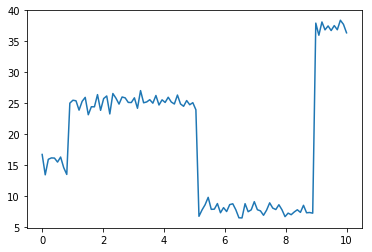

In [0]:
#Then we generate some testing data
from bisect import bisect
from matplotlib import pyplot as plt


xrange = 10
npnts = 100
nsegs = 4
intensity = 50
x = np.linspace(0, xrange, npnts).reshape(npnts, 1)
splits = [0]+list(sorted(np.random.uniform(0, xrange, nsegs-1)))
values = np.random.rand(nsegs) * intensity
y = np.zeros_like(x)
for i in range(y.shape[0]):
    index = bisect(splits, x[i]) - 1
    y[i, 0] = values[index] + np.random.randn(1)
plt.plot(x.reshape(-1), y.reshape(-1))
plt.show()

In [0]:
#Initialize the gradient boosting regression tree instance
gbrt = GBRT(10, 2, 0.1)

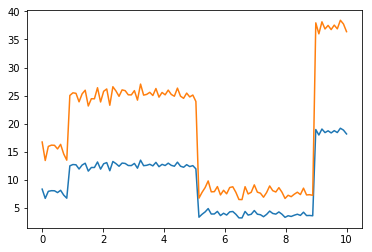

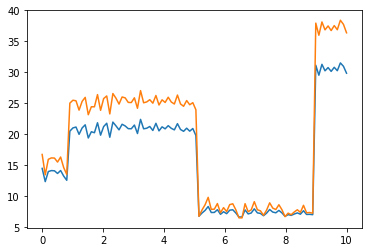

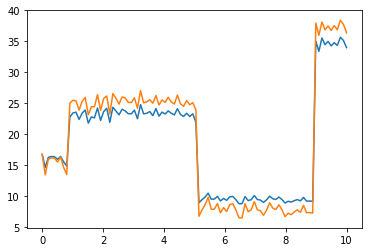

In [0]:
for i in range(60):
    gbrt.add_tree(x, y)
    yhat = gbrt.predict(x)
    if i % 20 == 0:
        plt.plot(x.reshape(-1), yhat.reshape(-1))
        plt.plot(x.reshape(-1), y.reshape(-1))